In [1]:
import math
import nltk
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

analyser = SentimentIntensityAnalyzer()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [2]:
# train = pd.read_csv('/Users/mtjen/Desktop/313/project/train.csv')
train = pd.read_csv('train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


target
0    0.57034
1    0.42966
Name: id, dtype: float64


<AxesSubplot:ylabel='id'>

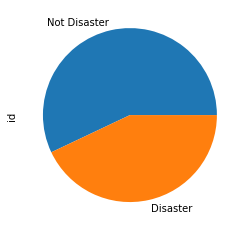

In [3]:
# Data Exploration
targets = train.groupby('target').count()['id']
ratio = targets/(targets.sum())
targets.plot(kind='pie', labels=['Not Disaster', 'Disaster'])
print(f"{}")

# Check for missing data
print()
print(train_df.isnull().sum)

In [4]:
# clean tweets    
def clean_non_printable(text):
    cleaned = ''.join([word for word in text if word.isprintable()])
    return cleaned

def clean_char_references(text):
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', text)
    return cleaned

train['text'] = train['text'].apply(clean_non_printable)
train['text'] = train['text'].apply(clean_char_references)


cleanedTweets = []

for index in range(len(train)):
    tweet = train['text'][index]
    cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    cleanedTweets.append(cleaned)
    
train['cleanedTweets'] = cleanedTweets

# textblob sentiment
train["sentimentText"] = train['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)

# vader sentiment
train["sentimentVader"] = train['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])

# move target to end
col = train.pop('target')
train.insert(len(train.columns), 'target', col)

train

,id,keyword,location,text,cleanedTweets,sentimentText,sentimentVader,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,0.000000,0.2732,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,0.100000,-0.3400,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,-0.018750,-0.2960,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,0.000000,0.0000,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,0.000000,-0.4939,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,aria_ahrary thetawniest the out of control wil...,0.150000,-0.5849,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m194 0104 utc5km s of volcano hawaii httptcozd...,0.000000,0.0000,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,police investigating after an ebike collided w...,-0.260417,-0.7845,1


In [5]:
##### added proper noun

charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []
charsPerSentenceTweet = []
numSentencesTweet = []
numProperNoun = []


for index in range(len(train)):
    ##### location
    location = 0
    if pd.isnull(train['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(train['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = train['text'][index]
    # number of characters in tweets
    numCharsTweet = len(text)
    
    # average number of characters in sentence
    sentences = text.split('.')
    charsPerSentence = []
    for sentence in sentences:
        numCharsSentence = len(sentence)
        charsPerSentence.append(numCharsSentence)
    avgCharsPerSentence = np.mean(charsPerSentence)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    properNounNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if (wordType == 'NNP') or (wordType == 'NNPS'):
            properNounNum += 1
        elif wordType in nouns:
            nounNum += 1
        elif wordType in verbs:
            verbNum += 1
        elif wordType == 'IN':
            prepNum += 1
        elif wordType in adj:
            adjNum += 1
        elif wordType in adv:
            advNum += 1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words and sentences
    numWords = len(words)
    numSentences = len(sentences)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)
    charsPerSentenceTweet.append(avgCharsPerSentence)
    numSentencesTweet.append(numSentences)
    numProperNoun.append(properNounNum)

    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)

In [6]:
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv, 
             charsPerSentenceTweet, numSentencesTweet, numProperNoun]

# create new dataframe
data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals


    
hashPerSentence = []
wordsPerSentence = []
atPerSentence = []
commasPerSentence = []
linksPerSentence = []

for index in range(len(data)):
    numSentences = data['numSentencesTweet'][index]
    numHash = data['numHash'][index]
    numWords = data['numberOfWords'][index]
    numAt = data['numAt'][index]
    numComma = data['numComma'][index]
    numLinks = data['numLinks'][index]
    
    hashPer = numHash / numSentences
    wordsPer = numWords / numSentences
    atPer = numAt / numSentences
    commasPer = numComma / numSentences
    linksPer = numLinks / numSentences
    
    hashPerSentence.append(hashPer)
    wordsPerSentence.append(wordsPer)
    atPerSentence.append(atPer)
    commasPerSentence.append(commasPer)
    linksPerSentence.append(linksPer)
    
    
data['hashPerSentence'] = hashPerSentence
data['wordsPerSentence'] = wordsPerSentence
data['atPerSentence'] = atPerSentence
data['commasPerSentence'] = commasPerSentence
data['linksPerSentence'] = linksPerSentence

In [7]:
# Vectorize contents of all tweets
# from sklearn.feature_extraction.text import CountVectorizer
# import pandas as pd

# countvectorizer = CountVectorizer(analyzer ='word', stop_words='english')

# count_wm = countvectorizer.fit_transform(train['text'])

# #retrieve the terms found in the corpora
# count_tokens = countvectorizer.get_feature_names()

# df_countvect = pd.DataFrame(data = count_wm.toarray(),index = list(train.index.values) ,columns = count_tokens)

# print("Count Vectorizer\n")
# print(df_countvect.shape)

# # Remove entries with junk characters
# # dont really know why they show up
# def isascii(s):
#     """Check if the characters in string s are in ASCII, U+0-U+7F."""
#     return len(s) == len(s.encode())

# for col in list(df_countvect.columns):
#     if isascii(col) == False:
#         df_countvect = df_countvect.drop([col], axis=1)

# print(df_countvect.shape)

In [ ]:
# Reduce size of vectorized tweets


In [ ]:
# # Get TTR (type-token ratio)
# occurances = []
# counts = []
# for tweet in range(len(df_countvect)):
#     occ = 0
#     count = 0
#     for word in range(len(df_countvect.iloc[tweet])):
#         if df_countvect.iloc[tweet, word] != 0:
#             count+=df_countvect.iloc[tweet, word]
#             occ +=1
#     occurances.append(occ)
#     counts.append(count)
#     print(tweet)

# ttr = []
# for i in range(len(occurances)):
#     if occurances[i] ==0:
#         ttr.append(0)
#         continue
#     ttr.append(occurances[i]/counts[i])
# print(ttr)

In [8]:
# data['ttr'] = ttr
data['sentimentText'] = train['sentimentText']
data['sentimentVader'] = train['sentimentVader']
data['target'] = train['target']

# save some stuff to csv for quick reaccess
data.to_csv('features.csv')
# pd.DataFrame(ttr).to_csv('ttr.csv')

data

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,numSentencesTweet,numProperNoun,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,0,0,1,0,...,1,4,0.000000,13.000000,0.0,0.000000,0.00,0.000000,0.2732,1
1,0,0,38,7,0,0,0,0,0,1,...,2,5,0.000000,3.500000,0.0,0.500000,0.00,0.100000,-0.3400,1
2,0,0,133,22,0,0,0,0,0,1,...,2,1,0.000000,11.000000,0.0,0.500000,0.00,-0.018750,-0.2960,1
3,0,0,65,8,0,1,0,0,1,0,...,1,1,0.000000,8.000000,1.0,0.000000,0.00,0.000000,0.0000,1
4,0,0,88,16,0,0,0,0,2,0,...,1,2,0.000000,16.000000,0.0,0.000000,0.00,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,0,0,0,1,0,1,...,2,0,0.000000,5.500000,0.0,0.500000,0.00,0.000000,-0.4939,1
7609,0,0,125,20,0,0,2,0,0,2,...,3,3,0.666667,6.666667,0.0,0.666667,0.00,0.150000,-0.5849,1
7610,0,0,65,8,0,0,0,1,0,3,...,4,6,0.000000,2.000000,0.0,0.750000,0.25,0.000000,0.0000,1
7611,0,0,137,19,0,0,0,0,0,2,...,3,4,0.000000,6.333333,0.0,0.666667,0.00,-0.260417,-0.7845,1


In [9]:
# data = pd.read_csv('features.csv')


In [10]:
corr = data.corr()
top10 = abs(corr.loc['target']).sort_values(ascending=False)[1:16]
print(top10)
top10 = list(top10.index.values)

sentimentVader        0.232405
commasPerSentence     0.203574
numQ                  0.195455
numConsonantsTweet    0.190908
tweetNumberOfChars    0.184401
numLettersTweet       0.182460
numNumericTweet       0.172301
numComma              0.156265
numSentencesTweet     0.156265
numPrep               0.155628
numVowelsTweet        0.151178
avgCharsPerWord       0.137535
wordsPerSentence      0.117802
numNouns              0.111260
hashPerSentence       0.104304
Name: target, dtype: float64


<AxesSubplot:>

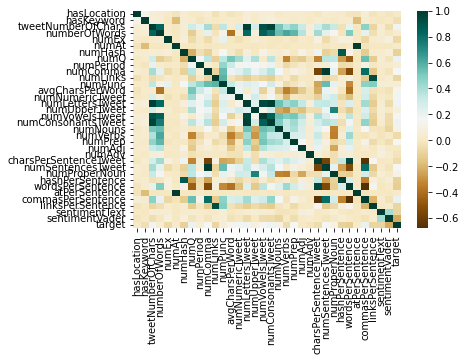

In [11]:
# Make heatmap to visualize
import seaborn as sns
sns.heatmap(corr, cmap='BrBG', yticklabels=True, xticklabels=True)

In [12]:
data_for_model = data
# data_for_model = data[top10]
# data_for_model['target'] = train['target']


data_for_model

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,numSentencesTweet,numProperNoun,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,0,0,1,0,...,1,4,0.000000,13.000000,0.0,0.000000,0.00,0.000000,0.2732,1
1,0,0,38,7,0,0,0,0,0,1,...,2,5,0.000000,3.500000,0.0,0.500000,0.00,0.100000,-0.3400,1
2,0,0,133,22,0,0,0,0,0,1,...,2,1,0.000000,11.000000,0.0,0.500000,0.00,-0.018750,-0.2960,1
3,0,0,65,8,0,1,0,0,1,0,...,1,1,0.000000,8.000000,1.0,0.000000,0.00,0.000000,0.0000,1
4,0,0,88,16,0,0,0,0,2,0,...,1,2,0.000000,16.000000,0.0,0.000000,0.00,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,0,0,0,1,0,1,...,2,0,0.000000,5.500000,0.0,0.500000,0.00,0.000000,-0.4939,1
7609,0,0,125,20,0,0,2,0,0,2,...,3,3,0.666667,6.666667,0.0,0.666667,0.00,0.150000,-0.5849,1
7610,0,0,65,8,0,0,0,1,0,3,...,4,6,0.000000,2.000000,0.0,0.750000,0.25,0.000000,0.0000,1
7611,0,0,137,19,0,0,0,0,0,2,...,3,4,0.000000,6.333333,0.0,0.666667,0.00,-0.260417,-0.7845,1


In [13]:
# split to train and test data
trainData = data_for_model.sample(frac = 0.8, random_state = 25)
testData = data_for_model.drop(trainData.index)

stopIndex = data_for_model.shape[1] - 1

trainArray = trainData.values
trainX = trainArray[:,0:stopIndex]
trainY = trainArray[:,stopIndex]

testArray = testData.values
testX = testArray[:,0:stopIndex]
testY = testArray[:,stopIndex]

# look into exact implementation of random forest
model = RandomForestClassifier()
model.fit(trainX, trainY)
# score = model.score(testX, testY)


RandomForestClassifier()

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# Get features and labels
X = data_for_model.drop(['target'], axis=1)
y = data_for_model['target']


cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
# roc_auc: aread under the curve, reciever operating characteristics
print(cv_scores)

print(cv_scores.mean())

[0.7007874  0.72965879 0.64829396 0.67542707 0.68988173 0.66228647
 0.70170828 0.64520368 0.75689882 0.67805519]
0.6888201392697135


In [18]:
# Randomly fit different hyperparameters to find optimal

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
model_random.fit(trainX, trainY)
# print results
print(model_random.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\jexia\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 300}


In [19]:
# New model
model = RandomForestClassifier(n_estimators=1000, max_depth=300, max_features='auto')
model.fit(trainX, trainY)

cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(cv_scores)

print(cv_scores.mean())

[0.68897638 0.72572178 0.64829396 0.67279895 0.69645204 0.67279895
 0.70959264 0.66885677 0.75821288 0.68988173]
0.6931586081306197


In [20]:
# import the kaggle unlabeled data, feature extract, and predict
test = pd.read_csv('test.csv')

# clean tweets    
def clean_non_printable(text):
    cleaned = ''.join([word for word in text if word.isprintable()])
    return cleaned
def clean_char_references(text):
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', text)
    return cleaned
test['text'] = test['text'].apply(clean_non_printable)
test['text'] = test['text'].apply(clean_char_references)
cleanedTweets = []
for index in range(len(test)):
    tweet = test['text'][index]
    cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    cleanedTweets.append(cleaned)
test['cleanedTweets'] = cleanedTweets
# textblob sentiment
test["sentimentText"] = test['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)
# vader sentiment
test["sentimentVader"] = test['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])
charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []
charsPerSentenceTweet = []
numSentencesTweet = []
numProperNoun = []


for index in range(len(test)):
    ##### location
    location = 0
    if pd.isnull(test['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(test['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = test['text'][index]
    # number of characters in tweets
    numCharsTweet = len(text)
    
    # average number of characters in sentence
    sentences = text.split('.')
    charsPerSentence = []
    for sentence in sentences:
        numCharsSentence = len(sentence)
        charsPerSentence.append(numCharsSentence)
    avgCharsPerSentence = np.mean(charsPerSentence)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    properNounNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if (wordType == 'NNP') or (wordType == 'NNPS'):
            properNounNum += 1
        elif wordType in nouns:
            nounNum += 1
        elif wordType in verbs:
            verbNum += 1
        elif wordType == 'IN':
            prepNum += 1
        elif wordType in adj:
            adjNum += 1
        elif wordType in adv:
            advNum += 1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words and sentences
    numWords = len(words)
    numSentences = len(sentences)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)
    charsPerSentenceTweet.append(avgCharsPerSentence)
    numSentencesTweet.append(numSentences)
    numProperNoun.append(properNounNum)

    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)
    
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv, 
             charsPerSentenceTweet, numSentencesTweet, numProperNoun]

# create new dataframe
data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals


    
hashPerSentence = []
wordsPerSentence = []
atPerSentence = []
commasPerSentence = []
linksPerSentence = []

for index in range(len(data)):
    numSentences = data['numSentencesTweet'][index]
    numHash = data['numHash'][index]
    numWords = data['numberOfWords'][index]
    numAt = data['numAt'][index]
    numComma = data['numComma'][index]
    numLinks = data['numLinks'][index]
    
    hashPer = numHash / numSentences
    wordsPer = numWords / numSentences
    atPer = numAt / numSentences
    commasPer = numComma / numSentences
    linksPer = numLinks / numSentences
    
    hashPerSentence.append(hashPer)
    wordsPerSentence.append(wordsPer)
    atPerSentence.append(atPer)
    commasPerSentence.append(commasPer)
    linksPerSentence.append(linksPer)
    
    
data['hashPerSentence'] = hashPerSentence
data['wordsPerSentence'] = wordsPerSentence
data['atPerSentence'] = atPerSentence
data['commasPerSentence'] = commasPerSentence
data['linksPerSentence'] = linksPerSentence

# data['ttr'] = ttr
data['sentimentText'] = test['sentimentText']
data['sentimentVader'] = test['sentimentVader']


# save some stuff to csv for quick reaccess
# data.to_csv('features.csv')
# pd.DataFrame(ttr).to_csv('ttr.csv')

data

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,charsPerSentenceTweet,numSentencesTweet,numProperNoun,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader
0,0,0,34,6,0,0,0,0,0,0,...,34.00,1,0,0.0,6.00,0.0,0.00,0.0,-1.00,-0.7003
1,0,0,64,9,0,1,0,0,1,1,...,31.50,2,2,0.0,4.50,0.5,0.50,0.0,0.25,0.4404
2,0,0,96,19,0,2,0,0,0,0,...,96.00,1,0,0.0,19.00,2.0,0.00,0.0,0.00,-0.6159
3,0,0,40,4,0,0,0,0,2,1,...,19.50,2,1,0.0,2.00,0.0,0.50,0.0,0.00,0.0000
4,0,0,45,8,0,0,0,0,0,0,...,45.00,1,4,0.0,8.00,0.0,0.00,0.0,0.00,-0.5423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,54,8,0,0,0,0,0,0,...,54.00,1,8,0.0,8.00,0.0,0.00,0.0,0.00,0.6808
3259,0,0,134,23,0,0,0,0,0,3,...,32.75,4,2,0.0,5.75,0.0,0.75,0.0,-0.20,-0.1531
3260,0,0,55,6,0,0,0,1,0,1,...,27.00,2,2,0.0,3.00,0.0,0.50,0.0,-0.20,0.0000
3261,0,0,65,7,0,0,0,1,0,1,...,32.00,2,5,0.0,3.50,0.0,0.50,0.0,0.60,0.0000


In [30]:
# Create predictions on test set based on model
prediction = pd.Series(model.predict(data))


In [35]:
prediction = predict.apply(np.int64)

submission = {'id': test['id'], 
             'target': prediction}

submission = pd.concat(submission, axis=1)
submission

submission.to_csv('submission.csv', index = False)